In [1]:
import pandas as pd
df=pd.read_excel('Customer_Concern_Areas.xlsm')
df_features=df[['overall','reviewText','summary']]
df_features.dropna(inplace=True)
df_features.head()

C:\Users\kotad\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,overall,reviewText,summary
0,5,We got this GPS for my husband who is an (OTR)...,Gotta have GPS!
1,1,"I'm a professional OTR truck driver, and I bou...",Very Disappointed
2,3,"Well, what can I say. I've had this unit in m...",1st impression
3,2,"Not going to write a long review, even thought...","Great grafics, POOR GPS"
4,1,I've had mine for a year and here's what we go...,"Major issues, only excuses for support"


### User Defined Functions:

In [2]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# UDF of Data Cleaning:
def clean_text(st):
    stopwords_update=stopwords.words('english')+list(punctuation)
    try:
        clean_ls=[i for i in word_tokenize(st.lower()) if i not in stopwords_update]
        return(' '.join(clean_ls))
    except:
        pass
    
# UDF for Lemmatization:
def lemma(st):
    lemma=WordNetLemmatizer()
    try:
        lem_st=[lemma.lemmatize(i) for i in st.split()]
        return(' '.join(lem_st))
    except:
        pass

# UDF for Vectorization:
def vector_Tfidf(df_col,grams_min,grams_max,max_fea):
    tf=TfidfVectorizer(ngram_range=(grams_min,grams_max),max_features=max_fea)
    tf_df=pd.DataFrame(tf.fit_transform(df_col).toarray(),columns=tf.get_feature_names())
    return(tf_df)

def vector_count(df_col,grams_min,grams_max,max_fea):
    tf=CountVectorizer(ngram_range=(grams_min,grams_max),max_features=max_fea)
    tf_df=pd.DataFrame(tf.fit_transform(df_col).toarray(),columns=tf.get_feature_names())
    return(tf_df)

# UDF for Sentiment score:
def sentiment(df_col):
    ls_sent=[]
    for i in range(len(df_col)):
        analyzer=SentimentIntensityAnalyzer()
        ls_sent.append(analyzer.polarity_scores(df_col.iloc[i])['compound'])
    return(ls_sent)


### 1.Clean the data

In [3]:
ls_clean_text=[]
for i in range(len(df_features)):
    ls_clean_text.append(lemma(clean_text(df_features.iloc[i].values[1])))
    
df_clean=pd.DataFrame(ls_clean_text,columns=['Clean_Review_Text'])
df_clean.dropna(inplace=True)
#For summary column
ls_clean_text=[]
for i in range(len(df_features)):
    ls_clean_text.append(lemma(clean_text(df_features.iloc[i].values[2])))
df_clean['rating']=df_features['overall']
df_clean['Clean_Summary']=ls_clean_text
df_clean.head()

,Clean_Review_Text,rating,Clean_Summary
0,got gps husband otr road trucker impressed shi...,5.0,got ta gps
1,'m professional otr truck driver bought tnd 70...,1.0,disappointed
2,well say 've unit truck four day prior garmin ...,3.0,1st impression
3,going write long review even thought unit dese...,2.0,great grafics poor gps
4,'ve mine year 's got try route non truck route...,1.0,major issue excuse support


### 2.	Plot a bigram bar graph on the top words 25 words

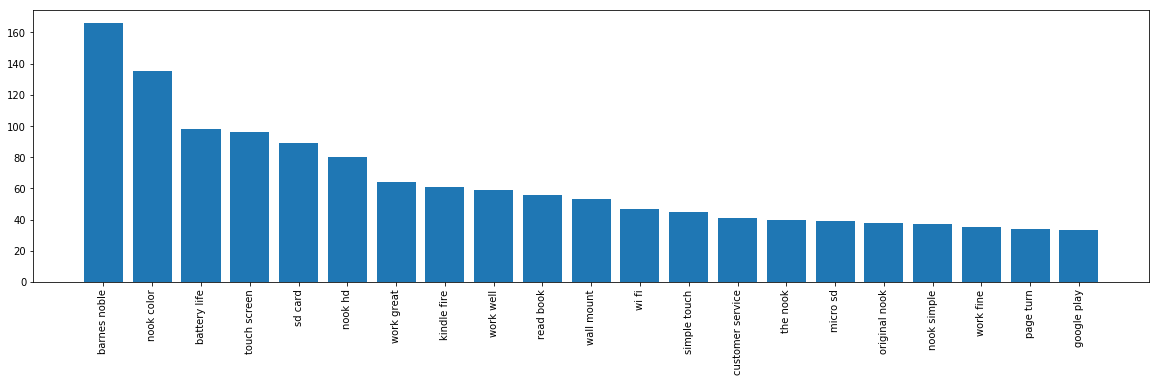

In [8]:
df_bigrams=vector_count(df_clean['Clean_Review_Text'],2,2,25)
from matplotlib import pyplot as plt
ls_sum=[]
d={}
plt.figure(figsize=(20,5))
for i in df_bigrams.columns:
    ls_sum.append(df_bigrams[i].sum())
    d[df_bigrams[i].sum()]=i
d2=dict(sorted(d.items(),reverse=True))    
plt.bar(d2.values(),d2.keys())
plt.xticks(rotation='vertical')
plt.show()

### 3.Get the sentiment score and prediction

In [5]:
#Assumption to Predict rating based on the sentiment score: 
# Sentiment score between -1 and +1 
#Original Rating class:
    # 1 to 3 - bad - 0
    # 4 to 5 - good -1
#Sentiment score:
    # -1 to 0 - bad - 0
    #0 to 1 - good - 1
#positive sentiment : (compound score >= 0.05)
#neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
#negative sentiment : (compound score <= -0.05)

# Prediction using Sentiment score
ls_sen=sentiment(df_clean['Clean_Review_Text'])
df_clean['Sentiment_Score']=ls_sen
ls_Sent_Vader=[]
for i in range(len(df_clean)):
    if -1<=df_clean['Sentiment_Score'].iloc[i]<=0:
        ls_Sent_Vader.append(0)
    elif 0<df_clean['Sentiment_Score'].iloc[i]<=1:
        ls_Sent_Vader.append(1)
                   
# Original rating classification:
ls_rating_class=[]
for i in range(len(df_clean)):
    if 1<=df_clean['rating'].iloc[i]<=3:
        ls_rating_class.append(0)
    elif 3<df_clean['rating'].iloc[i]<=5:
        ls_rating_class.append(1)    
    else:
        ls_rating_class.append(0)
df_clean['original_rating_class']=ls_rating_class
df_clean['Rating_Sent_vader']=ls_Sent_Vader
df_clean['rating'].fillna(2.5,inplace=True)
df_clean['rating']=df_clean['rating'].astype(int)
from sklearn.metrics import confusion_matrix,accuracy_score
print('Accuracy between original rating an Sentiment_vader_rating',round(accuracy_score(df_clean['original_rating_class'],df_clean['Rating_Sent_vader'])*100))
df_clean.head()


Accuracy between original rating an Sentiment_vader_rating 70.0


,Clean_Review_Text,rating,Clean_Summary,Sentiment_Score,original_rating_class,Rating_Sent_vader
0,got gps husband otr road trucker impressed shi...,5,got ta gps,0.9834,1,1
1,'m professional otr truck driver bought tnd 70...,1,disappointed,-0.3895,0,0
2,well say 've unit truck four day prior garmin ...,3,1st impression,0.9853,0,1
3,going write long review even thought unit dese...,2,great grafics poor gps,0.1533,0,1
4,'ve mine year 's got try route non truck route...,1,major issue excuse support,-0.7845,0,0


### Please do not refer below cell for eveluation, For practice only

In [7]:
def vector_Tfidf(df_col,grams_min,grams_max,max_fea):
    tf=TfidfVectorizer(ngram_range=(grams_min,grams_max),max_features=max_fea)
    tf_df=pd.DataFrame(tf.fit_transform(df_col).toarray(),columns=tf.get_feature_names())
    return(tf_df)
tf_df_ret=vector_Tfidf(df_clean['Clean_Review_Text'],2,2,1000)
tf_df_ret['original_rating']=df_clean['rating']
tf_df_ret['original_rating_class']=df_clean['original_rating_class']

from sklearn.decomposition import PCA
X=tf_df_ret[[i for i in tf_df_ret.columns if i not in ('original_rating','original_rating_class') ]]
Y=tf_df_ret[['original_rating','original_rating_class']]
pca=PCA(4)
df_pca=pd.DataFrame(pca.fit_transform(X))
df_pca.columns=['PCA1','PCA2','PCA3','PCA2']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
n=100
# For Rating 1 to 5
x_train,x_test,y_train,y_test=train_test_split(X,Y['original_rating'],test_size=0.15,stratify=Y)
rf=LinearRegression()
rf.fit(x_train,y_train)
y_test_pred=rf.predict(x_test)
y_test_pred=y_test_pred.astype(int)
print('LinerRegression',accuracy_score(y_test,y_test_pred))
y_pred_original=rf.predict(X)
tf_df_ret['predicted_rating']=y_pred_original

# For Rating class 0 to 1
x_train,x_test,y_train,y_test=train_test_split(X,Y['original_rating_class'],test_size=0.15,stratify=Y)
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
y_test_pred=rf.predict(x_test)
y_test_pred=y_test_pred.astype(int)
print('RandomForestRegressor',accuracy_score(y_test,y_test_pred))
y_pred_original_class=rf.predict(X)
tf_df_ret['predicted_class_rating']=y_pred_original_class


LinerRegression 0.09333333333333334
RandomForestRegressor 0.26666666666666666


### 4.Find customer concern areas - the top 25 bigrams which includes the below negative words indicating the customer concern areas 'poor', 'waste', 'bad', 'defective', 'disgusting', 'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow'
### 5.Plot a bar graph for the top 25 customer concern areas

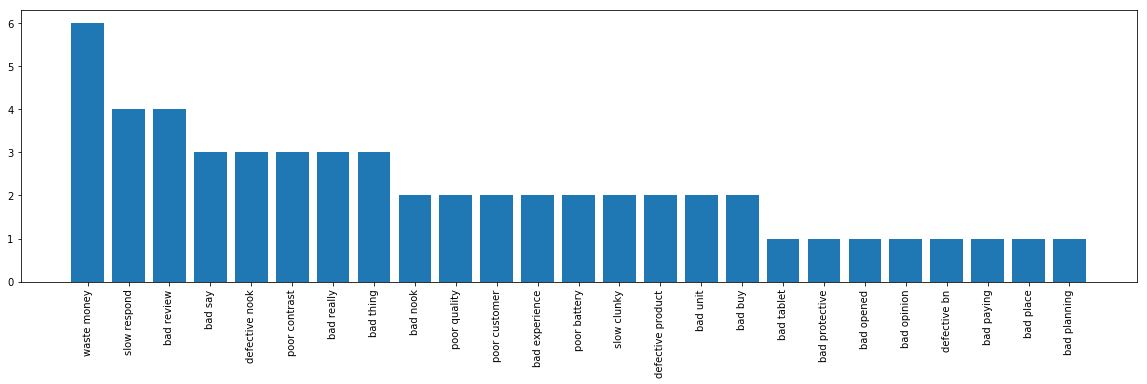

In [50]:
#Customizing according to the requirement 'vector_count':
def vector_count(df_col,grams_min,grams_max):
    tf=CountVectorizer(ngram_range=(grams_min,grams_max))
    tf_df=pd.DataFrame(tf.fit_transform(df_col).toarray(),columns=tf.get_feature_names())
    return(tf_df)

df_bigrams=vector_count(df_clean['Clean_Review_Text'],2,2)
ls_concern_comumns=[]
ls_concern=['poor', 'waste', 'bad', 'defective', 'disgusting', 'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow']
for i in df_bigrams.columns:
    if (i.split()[0] in ls_concern) or (i.split()[0] in ls_concern): 
        ls_concern_comumns.append(i)
df_bigrams_concern=df_bigrams[ls_concern_comumns]

from matplotlib import pyplot as plt
ls_sum=[]
d={}
plt.figure(figsize=(20,5))
for i in df_bigrams_concern.columns:
    #ls_sum.append(df_bigrams_concern[i].sum())
    d[i]=df_bigrams_concern[i].sum()
frame=pd.Series(d)
frame_2=frame.sort_values(ascending=False)[0:25]
from collections import OrderedDict    
d2=dict(sorted(d.items(),reverse=True))    
plt.bar(frame_2.index,frame_2.values)
plt.xticks(rotation='vertical')
plt.show()